# **IMPORTS**

First, we declare the imports for the whole notebook.

In [ ]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.optim import Adam
from torchvision.models import mobilenet_v3_small

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import copy

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Here we declare some constants throughout the notebook.

In [ ]:
IMAGES_PATH = "Tennis Player Actions Dataset for Human Pose Estimation/images"
DATA_SPLIT = [0.8, 0.1, 0.1]  # Train, Validation, Test
BATCH_SIZE = 128
MAX_DEGREES = 30
IMG_SIZE = (240, 240)
SEED = 42

# Precomputed with a separate script
MEAN = [126.7874, 129.6748, 120.0113]
STD = [58.5588, 57.8795, 59.8400]

# Use GPU if available
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
DEVICE

device(type='cuda')

Now, we will import the actions dataset. 

In [3]:
full_dataset = datasets.ImageFolder(root=IMAGES_PATH)
print(full_dataset.classes)

['backhand', 'forehand', 'ready_position', 'serve']


# **EDA & PREPROCESSING**

Now we will explore the data we are working with.

In [4]:
label_to_idx = full_dataset.class_to_idx
print(f"Number of images: {len(full_dataset.samples)}")
print(f"Number of classes: {len(label_to_idx)}")

Number of images: 2000
Number of classes: 4


We have 2000 images of 4 classes, with a small search we can see that we have 500 images of each class.

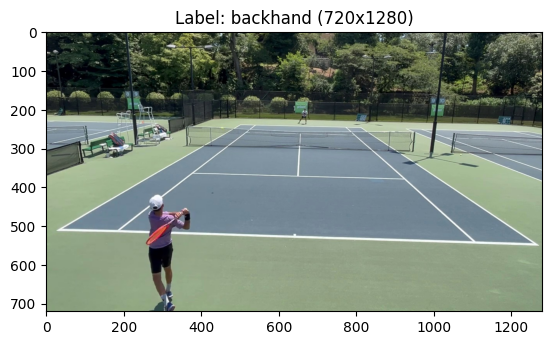

In [5]:
random_idx = random.randint(0, len(full_dataset.samples))
img = np.asarray(Image.open(full_dataset.samples[random_idx][0]))
label_idx = full_dataset.samples[random_idx][1]
label = [label for label, idx in label_to_idx.items() if idx == label_idx]

plt.imshow(img)
plt.title(f"Label: {label[0]} ({img.shape[0]}x{img.shape[1]})")
plt.show()

We observe that all images have (720x1280) resolution, we will have to deal with this later since big image sizes require more computing resources. We also check the four different types of labels we have: **forehand**, **backhand**, **ready_position** and **serve**. 

Next, we will divide the dataset into training, testing and validation. Moreover, we will apply some transformations to the data. Firstly, for all datasets we will **scale** them by using the precomputed mean and variance of each channel. Next, we will **resize** the images from (720x1280) to (240x240). This is because dealing with high resolution images takes lots of computing, and we could distinguish by eye-balling these classes even with that resolution. In addition, since we will use later pre-trained and hand-made networks, we use this image size to have the same transformation for all of them and compare their results fairly. 

For the training set we will do some added transformations to help generalization. First, we will do a **horizontal flip** of the image 50% of the time. This makes sense when you take into account that there are left and right-handed players, therefore the model should not based a prediction on if the racket is on the left or right, but on the overall gesture. Also, we will add some random **rotation** of some degrees to capture variation in camera setup and make the classification more robust. 

We also added the following transformations to the training set, firstly we **cropped the top 30%** of the image. We will dive at the end on this, but basically previous models focused on the sky and some buildings to make predictions, which is exactly what we do not want, so we cropped this to focus on the player. Next, we performed some **translation**, **scaling**, **color jitter** and random **grayscaling**. All of this transformations are used because previous models used to not focus on the player but on the environment. Then, randomizing some of the color and other cues should lead to better focus on the player and therefore better generalization.

In [6]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        img = self.transform(img) if self.transform else img
        return img, label

    def __len__(self):
        return len(self.subset)

In [ ]:
def remove_sky(img):
    """Remove top 30% of image sky"""
    _, h, _ = img.shape
    return img[:, int(h*0.3):, :]  # Keep bottom 70%

# Transform for testing and validation
test_transform = v2.Compose([
    v2.Resize(IMG_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=MEAN, std=STD)
])

# Transfrom for training
train_transform = v2.Compose([
    v2.ToImage(),
    v2.Lambda(remove_sky),
    v2.Resize(IMG_SIZE),

    # Aggressive augmentation
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=MAX_DEGREES),  
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    v2.RandomGrayscale(p=0.1),

    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=MEAN, std=STD)
])

In [8]:
generator = torch.Generator().manual_seed(SEED)
train, test, val = random_split(full_dataset, DATA_SPLIT, generator=generator)

# Specific subsets
train = TransformSubset(train, train_transform)
test = TransformSubset(test, test_transform)
val = TransformSubset(val, test_transform)

# Loaders for fast accessing
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val, BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")
print(f"Validation samples: {len(val)}")

Training samples: 1600
Testing samples: 200
Validation samples: 200


Now, let's check the training data after the transformations.

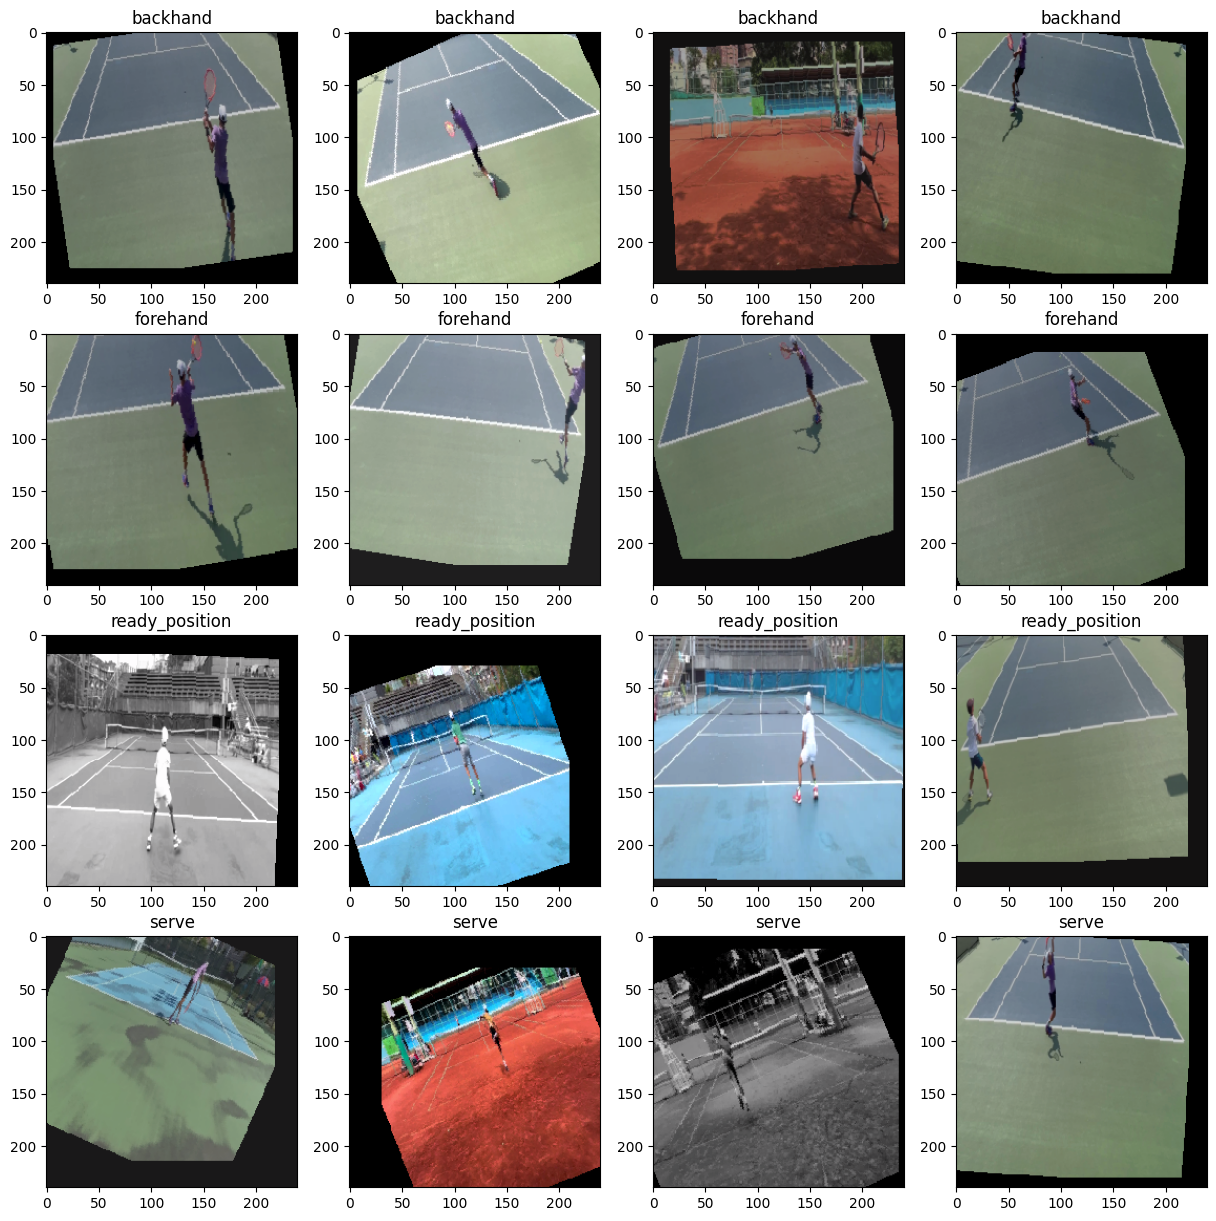

In [9]:
n_cols = 4
f, axarray = plt.subplots(len(label_to_idx), n_cols)
f.set_figheight(15)
f.set_figwidth(15)

idx_shown = [] 
for label in range(len(label_to_idx)):
    # Compute the class for the title 
    label_str = [l for l, idx in label_to_idx.items() if idx == label]

    for i in range(n_cols):
        # Get an image of that label
        while True: 
            random_idx = random.randint(0, len(train)-1)
            img, l = train[random_idx]

            # Stop the loop if its the row's label and the image has not been plotted
            if l == label and random_idx not in idx_shown: 
                idx_shown.append(random_idx)
                break


        img = np.asarray(img).transpose(1, 2, 0)  # Change the channels from the first to last axis
        img = img * STD + MEAN  # Unnormalize
        img = np.clip(img.astype(int), 0, 255)  # Convert to int and clip between 0 and 255 for plotting

        # Assign images
        axarray[label, i].imshow(img)
        axarray[label, i].set_title(label_str[0])

We see that the transforms have been correct where we have random flips and some images are flipped if we check backhand and forehand.

Then, the next step is to build and train some models.

# **CLASSIFICATION**

## Training & Testing Loops

Before doing any classification with different models, we need to create a loop for training and testing these models easily. In addition, we will add a way to save the best models, some statistics with tensorboard and some early stopping to not train more epochs when overfitting. 

In [10]:
# Tensorboard writer for visualization
writer = SummaryWriter()

In [11]:
def train(train_loader, val_loader, loss_fn, optimizer, model, n_epochs, device, save_path=None, patience=3):
    """
    Trains a model and evaluates it in a provided validation set.
    Returns an array of training and validations losses and accuracy per epoch.
    """
    model.to(device)  # Send model to CPU/GPU
    best_val_loss = np.inf  # Best validation loss (main metric)
    bad_epochs = 0  # Number of epochs without improving loss

    # Saving losses and accs for plotting
    train_losses = np.zeros(n_epochs)
    train_accs = np.zeros(n_epochs)
    val_losses = np.zeros(n_epochs)
    val_accs = np.zeros(n_epochs)

    for epoch in range(n_epochs): 
        # Training
        model.train()  # Set the model to training mode
        train_loss = 0
        train_acc = 0
        for batch, (data, labels) in enumerate(train_loader):
            # Send data and labels to CPU/GPU
            data = data.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Reset gradients
            preds = model(data)  # Predict training data
            loss = loss_fn(preds, labels)  # Calculate loss of the predictions
            loss.backward()  # Propagate the loss backwards
            optimizer.step()  # Update model parameters 

            batch_size = data.size(0) 
            train_loss += loss.item() * batch_size  # Multiply by batch size since loss is the mean
            train_acc += (preds.argmax(dim=1) == labels).sum().item()

        # Calculate loss and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
        train_losses[epoch] = train_loss
        train_accs[epoch] = train_acc

        # Add metrics to tensorboard
        writer.add_scalar("training loss", train_loss, epoch)
        writer.add_scalar("training accuracy", train_acc, epoch)

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_acc = 0
        with torch.no_grad():  # Disable gradients
            for batch, (data, labels) in enumerate(val_loader): 
                # Send data and labels to CPU/GPU
                data = data.to(device)
                labels = labels.to(device)
                preds = model(data)  # Predict validation data

                batch_size = data.size(0) 
                val_loss += loss_fn(preds, labels).item() * batch_size  # Multiply by batch size since loss is the mean
                preds = preds.argmax(dim=1)  # Get the class with highest probability
                val_acc += (preds == labels).sum().item()

        # Calculate loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc / len(val_loader.dataset)
        val_losses[epoch] = val_loss
        val_accs[epoch] = val_acc

        # Add metrics to tensorboard
        writer.add_scalar("validation loss", val_loss, epoch)
        writer.add_scalar("validation accuracy", val_acc, epoch)

        print(f"Epoch: {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.3f}; Train Accuracy: {train_acc*100:.3f}% | "
              f"Validation Loss: {val_loss:.3f}; Validation Accuracy: {val_acc*100:.3f}%")
        
        # Save the model if it has the lowest recorded loss
        if save_path and val_loss < best_val_loss:
            print("Saving best model")
            best_val_loss = val_loss
            bad_epochs = 0
            best_state = copy.deepcopy(model.state_dict())  # Using deepcopy to maintain best params even after training more epochs
            torch.save(model.state_dict(), save_path)
        else: 
            bad_epochs +=1

        # Early stopping if the model does not improve
        if bad_epochs >= patience: 
            print(f"Early stopping at epoch {epoch+1}. Restoring best model (validation loss = {best_val_loss:.3f})")
            # Restore best model
            if best_state: 
                model.load_state_dict(best_state)

            # Trim results
            train_losses = train_losses[:epoch+1]
            train_accs = train_accs[:epoch+1]
            val_losses = val_losses[:epoch+1]
            val_accs = val_accs[:epoch+1]
            break

    return train_losses, train_accs, val_losses, val_accs
        

In [12]:
def test(test_loader, model, loss_fn, device):
    """"
    Tests a model on a given testing set. 
    Returns the loss and accuracy.
    """

    model.to(device)
    model.eval()

    running_loss = 0
    acc = 0
    probs = np.zeros((len(test_loader.dataset), 4))

    with torch.no_grad():
        idx = 0
        for batch, (data, labels) in enumerate(test_loader):
            # Send data and labels to CPU/GPU
            data = data.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            bs = data.size(0)
            
            # Predict labels and accumulate loss and acc
            preds = model(data)
            running_loss += loss_fn(preds, labels).item() * bs
            acc += (preds.argmax(dim=1) == labels).sum().item()

            # Set output probabilities
            probs[idx:idx+bs, :] = torch.softmax(preds, dim=1).detach().cpu().numpy()

            idx += bs


    # Calculate loss and accuracy
    loss = running_loss / len(test_loader.dataset) 
    acc = acc / len(test_loader.dataset) 

    print(f"Test Loss: {loss:.3f}; Test Accuracy: {acc:.3f}")

    return probs, loss, acc


## Pre-trained Model

Now that we have the training and testing loop we can train a model with our data, but first we need the model. Because of this task being kind of hard, we either would need lots of different images if we want to train a network from scratch. Since this is not the case, we will use **transfer learning**, which consists on taking a pre-trained model and tweaking it for our specific task.

The pre-trained model we will use is **MobileNet-v3 Small**, which is a net created for inference on phones. Because of this, it is light-weight and easily tunable, which is what we need. The model achieves this efficiency by using techniques such as: depth-wise convolution (instead of 3-dimensional); a bottleneck before convolution to reduce dimensionality, and an expansion block after to restore dimensionality; and passing residuals for easier gradient propagation. More on the model's architecture in this Medium <a href="https://medium.com/@RobuRishabh/understanding-and-implementing-mobilenetv3-422bd0bdfb5a">article</a>.  

<img src="mobilenet_v2.png" alt="MobileNet-V2's architecture" width="1200" height="500">
<i>MobileNet-V2's architecture</i>

We can now load the model.

In [ ]:
# Load the model
mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

# Number of feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

# Number of classifier layers
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Number of feature layers: 13
Number of classifier layers: 4


For fine-tuning, we won't use all layers, just the last ones. Usually the first ones retain the spatial information of the original training set, so we will only need to tweak the last few layers to adjust our predictions. Moreover, we will need to change the last classifying layer to adjust it to our problem (4 classes).

In [ ]:
# Freeze the earlier layers to retain pretrained low-level features
for param in mobilenetv3_model.features[:10].parameters():  
    param.requires_grad = False

# Adjust last classifying layer
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 4, bias = True)

# Check the final classifier after modifications
print(mobilenetv3_model.classifier[3])

# Model for training
mobilenet = mobilenetv3_model

Linear(in_features=1024, out_features=4, bias=True)


The next step is doing the training loop. Before this, we have to declare the loss function and optimizer to use.

For the first one we will use the **Cross Entropy Loss**, which is the most common for classification tasks. To put it simply, this function measures the error between the model's output probabilities and the ground truth. This contrasts with a metric like accuracy, where we only focus on the model's predicted class and not probability.

For the optimizer, we will use **Adam**, which again is one of the most common. It uses gradient descent to calculate the parameters that minimize the loss. Its main advantage is having custom learning rates for each parameter, which makes convergence faster.

In [ ]:
# Loop parameters
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # label smoothing to stop model overconfidence 
optimizer = Adam(mobilenet.parameters(), lr=1e-3)
n_epochs = 30
path = "models/MobileNet/08-11-2025.pt"

# Training loop
train_losses, train_accs, val_losses, val_accs = train(train_loader, val_loader, loss_fn, optimizer, 
                                                       mobilenet, n_epochs, DEVICE, save_path=path, patience=10)


Epoch: 1/30 | Train Loss: 1.101; Train Accuracy: 54.062% | Validation Loss: 1.362; Validation Accuracy: 53.500%
Saving best model
Epoch: 2/30 | Train Loss: 0.831; Train Accuracy: 74.312% | Validation Loss: 1.273; Validation Accuracy: 57.500%
Saving best model
Epoch: 3/30 | Train Loss: 0.758; Train Accuracy: 79.312% | Validation Loss: 0.979; Validation Accuracy: 67.000%
Saving best model
Epoch: 4/30 | Train Loss: 0.722; Train Accuracy: 79.625% | Validation Loss: 1.150; Validation Accuracy: 57.000%
Epoch: 5/30 | Train Loss: 0.662; Train Accuracy: 84.312% | Validation Loss: 0.920; Validation Accuracy: 64.000%
Saving best model
Epoch: 6/30 | Train Loss: 0.640; Train Accuracy: 84.688% | Validation Loss: 0.829; Validation Accuracy: 76.000%
Saving best model
Epoch: 7/30 | Train Loss: 0.611; Train Accuracy: 86.875% | Validation Loss: 0.774; Validation Accuracy: 78.500%
Saving best model
Epoch: 8/30 | Train Loss: 0.604; Train Accuracy: 88.938% | Validation Loss: 0.826; Validation Accuracy: 75.0

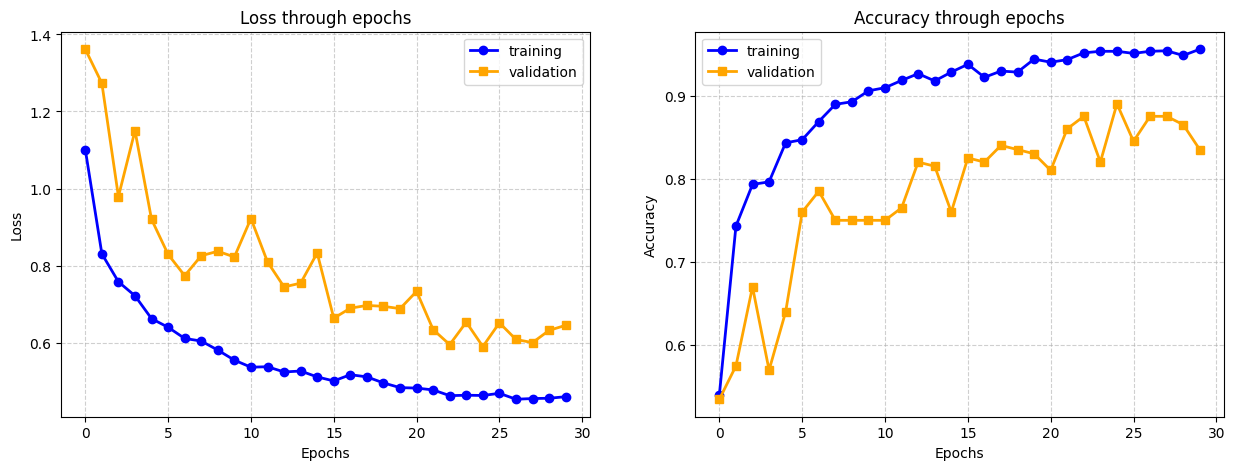

In [17]:
x = [i for i in range(len(train_losses))]

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

# Add labels and a title
ax[0].plot(x, train_losses, label="training", color="blue", linewidth=2, marker="o")
ax[0].plot(x, val_losses, label="validation", color="orange", linewidth=2, marker="s")
ax[0].set_title("Loss through epochs")
ax[0].legend()
ax[0].grid(linestyle='--', alpha=0.6)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(x, train_accs, label="training", color="blue", linewidth=2, marker="o")
ax[1].plot(x, val_accs, label="validation", color="orange", linewidth=2, marker="s")
ax[1].set_title("Accuracy through epochs")
ax[1].legend()
ax[1].grid(linestyle='--', alpha=0.6)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

Since we have already trained the model, we can load the best one, as we saved it.

In [32]:
mobilenet = mobilenet_v3_small(weights=None)  # or mobilenet_v3_large
mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=4, bias=True)

# 2. Load the saved weights
mobilenet.load_state_dict(torch.load('models/MobileNet/08-11-2025.pt'))


<All keys matched successfully>

Now, let's analyze carefully the model's predictions.

In [33]:
# Calculate class probabilities
loss_fn = nn.CrossEntropyLoss()
probs, losses, accs = test(val_loader, mobilenet, loss_fn, DEVICE)

Test Loss: 0.397; Test Accuracy: 0.890


We have an accuracy of around 89% which seems really good, let's check for each individual class.

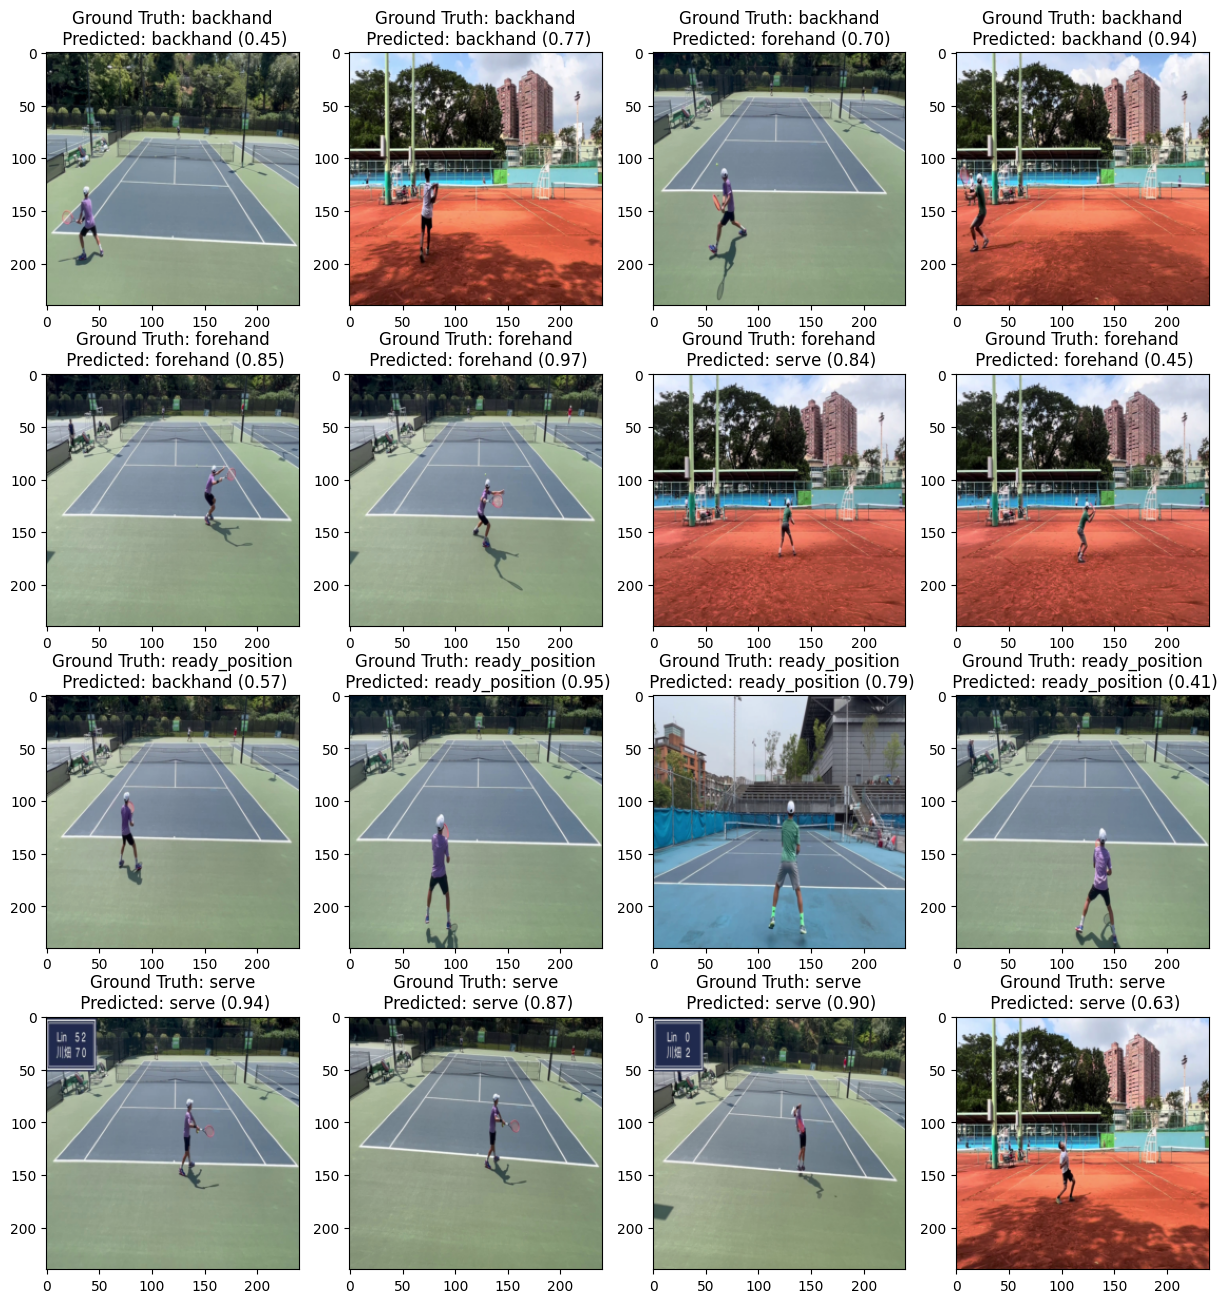

In [34]:
# Calculate class probabilities
preds = np.argmax(probs, axis=1)
highest_probs = np.max(probs, axis=1)

# Plot labels
n_cols = 4
f, axarray = plt.subplots(len(label_to_idx), n_cols)
f.set_figheight(16)
f.set_figwidth(15)

idx_shown = []
for label in range(len(label_to_idx)):
    # Compute the class for the title 
    label_str = [l for l, idx in label_to_idx.items() if idx == label]

    for i in range(n_cols):
        # Get an image of that label
        while True: 
            random_idx = random.randint(0, len(val)-1)
            img, l = val[random_idx]

            # Stop the loop if its the row's label and the image has not been plotted
            if l == label and random_idx not in idx_shown: 
                idx_shown.append(random_idx)
                break

        idx_shown.append(random_idx)
        img = np.asarray(img).transpose(1, 2, 0)  # Change the channels from the first to last axis
        img = img * STD + MEAN  # Unnormalize
        img = np.clip(img.astype(int), 0, 255)  # Convert to int and clip between 0 and 255 for plotting

        # Get predicted label
        pred_number = preds[random_idx]
        pred_label = [label for label, number in label_to_idx.items() if number == pred_number][0]

        # Assign images
        axarray[label, i].imshow(img)
        axarray[label, i].set_title(f"Ground Truth: {label_str[0]}\n Predicted: {pred_label} ({highest_probs[random_idx]:.2f})")

We can see that the model usually confuses between forehand and backhand having lower prediction probabilities overall while doing pretty good on serves. Let's see the confusion matrix to check what we have seen in this plot.

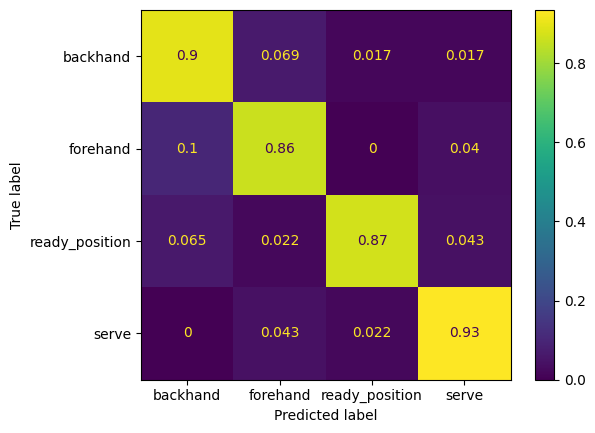

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = ("backhand", "forehand", "ready_position", "serve")

# Get ground truth labels
gt = []
for inputs, labels in val_loader:
        labels = labels.data.cpu().numpy()
        gt.extend(labels) 


# Build confusion matrix
cm = confusion_matrix(gt, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

Our intuition was right and the model confuses a lot with backhand forehand and also ready positon while doing really good on serves. For a complex task like this where it would be hard for some people to guess correctly consistently we are satisfied with the model predictions, specially since it's so simple. 


# **EXPLAINABILITY**

Neural Networks are black boxes, so extracting meaningful conclusions on how the model predicts is really hard. Despite this, we need this explainability in some domains, like health-related problems where we need to know why the model predicted what it did. In computer vision, we need a way to know what the model is focusing on, if we detect the model is relying on the wrong cues to make predictions we might want to change it or discard it. In our specific use-case we expect to see that the model is focusing on the player to make the predictions.

Luckily, we have different ways of doing this. Although the effectiveness of some of these techniques is under current research, we can use them as a guideline for the simple experiment we have done. The technique we will use is **Grad-CAM**. It takes a layer and weights the contribution of different channels to the prediction by computing the gradients with respect to the loss. Then it combines all of the channel's outputs weighed by their contribution and outputs a heatmap that represents what the model focuses on to make predictions. 

## Grad-CAM

In [45]:
def compute_gradcam(img):
    """
    Computes an image with the grad-CAM overlay of the given image and the model's predicted class
    """
    # Use the last layer for Grad-CAM
    target_layers = [mobilenet.features[-1]]
    # Make the image have shape (1, C, H, W)
    input_tensor = img.unsqueeze(0)

    # Compute the CAM for the predicted class
    mobilenet.eval()
    device = next(mobilenet.parameters()).device
    logits = mobilenet(input_tensor.to(device))
    pred_idx = int(logits.argmax(dim=1).item())
    targets = [ClassifierOutputTarget(pred_idx)]

    # Transformations to the image for plotting
    rgb_img = img
    rgb_img = np.asarray(rgb_img).transpose(1,2,0)
    rgb_img = rgb_img * STD + MEAN  # Unnormalize
    rgb_img = np.clip(rgb_img / 255, 0, 1)  

    with GradCAM(model=mobilenet, target_layers=target_layers) as cam:
        # Compute the CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]  # Only one image

        # Compute the image with the CAM overlay
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
    return visualization
    

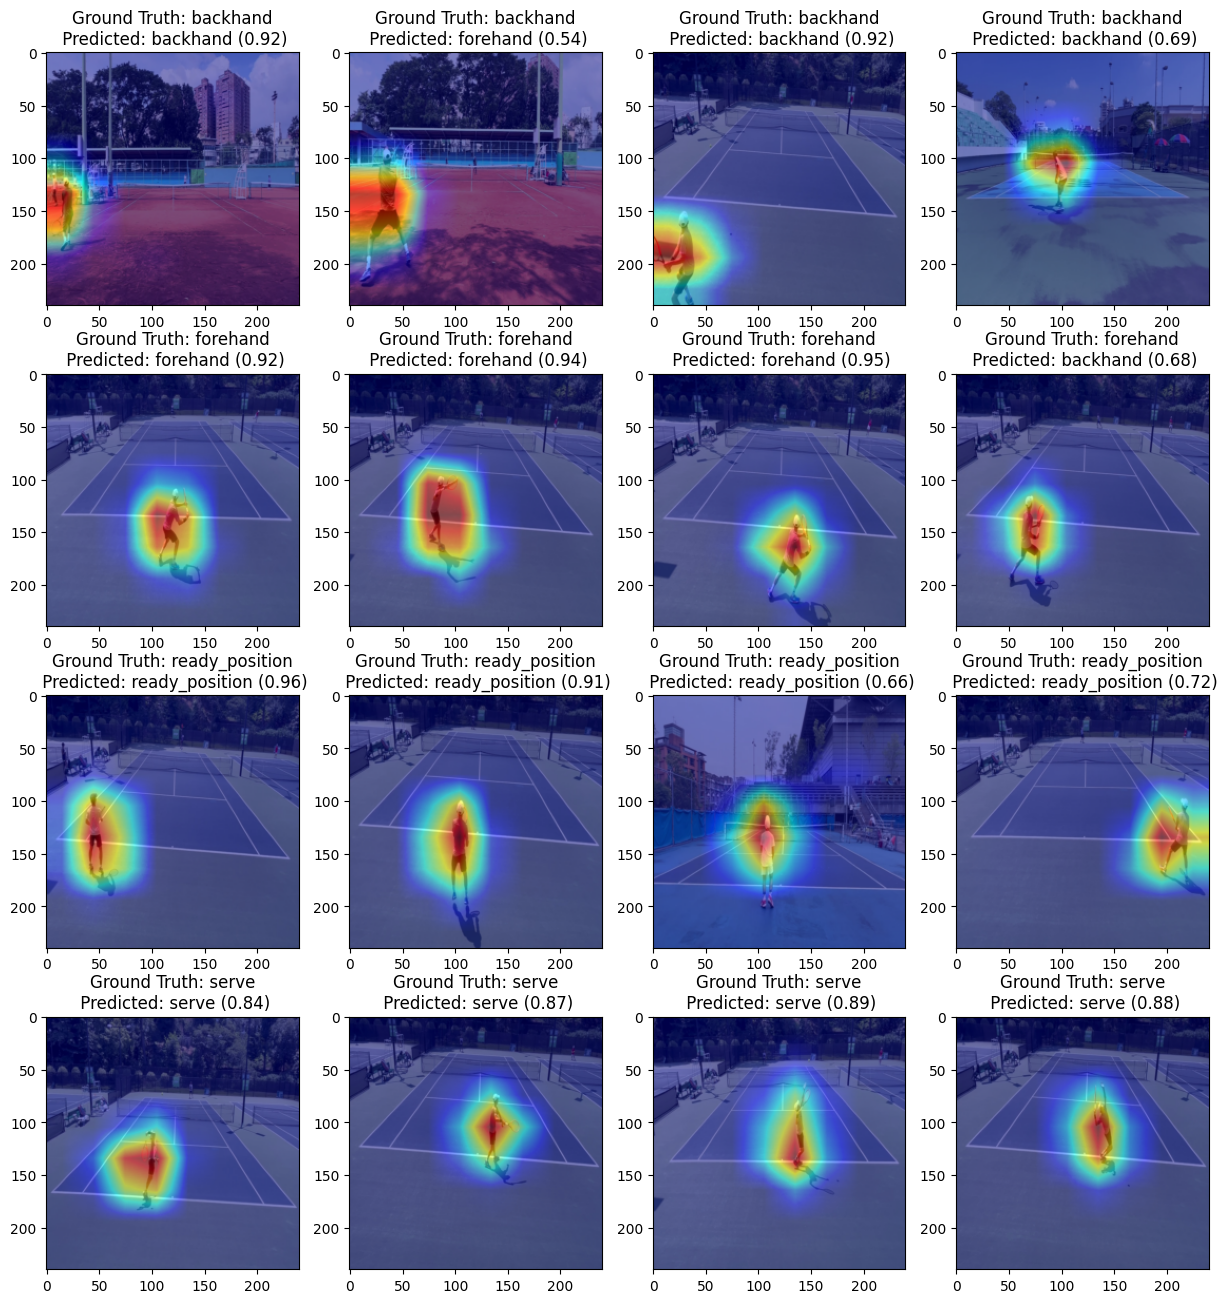

In [61]:
# Calculate class probabilities
preds = np.argmax(probs, axis=1)
highest_probs = np.max(probs, axis=1)

# Plot labels
n_cols = 4
f, axarray = plt.subplots(len(label_to_idx), n_cols)
f.set_figheight(16)
f.set_figwidth(15)

idx_shown = []
for label in range(len(label_to_idx)):
    # Compute the class for the title 
    label_str = [l for l, idx in label_to_idx.items() if idx == label]

    for i in range(n_cols):
        # Get an image of that label
        while True: 
            random_idx = random.randint(0, len(val)-1)
            img, l = val[random_idx]

            # Stop the loop if its the row's label and the image has not been plotted
            if l == label and random_idx not in idx_shown: 
                idx_shown.append(random_idx)
                break

        idx_shown.append(random_idx)
        # Compute the grad-CAM overlay
        gradcam_img = compute_gradcam(img)

        # Get predicted label
        pred_number = preds[random_idx]
        pred_label = [label for label, number in label_to_idx.items() if number == pred_number][0]

        # Assign images
        axarray[label, i].imshow(gradcam_img)
        axarray[label, i].set_title(f"Ground Truth: {label_str[0]}\n Predicted: {pred_label} ({highest_probs[random_idx]:.2f})")

plt.savefig("Grad-CAM overlay multiple.svg")

We see that the model consistently focuses on the player, with some errors of focus sometimes. We can also notice that in serves the model usually makes prediction with the top part of the body, while focusing on the middle with ready_position and more to the sides on backhand or forehand. This is a good-sign and means the model is truly generalizing.

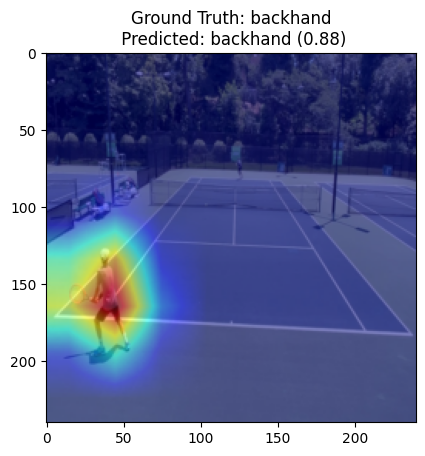

In [62]:
# Get image and label
img, l = val[1]
label_str = [label for label, number in label_to_idx.items() if number == l]

# Get predicted label
pred_number = preds[1]
pred_label = [label for label, number in label_to_idx.items() if number == pred_number][0]

# Compute grad-CAM overlay
gradcam_img = compute_gradcam(img)

# Plot image
plt.imshow(gradcam_img)
plt.title(f"Ground Truth: {label_str[0]}\n Predicted: {pred_label} ({highest_probs[random_idx]:.2f})")

plt.savefig("Grad-CAM overlay single.svg")

## Test

Now that we know the model is making predictions the right way, we only need to measure the accuracy of the model on the test set we left-out at the start.

In [64]:
# Calculate class probabilities
loss_fn = nn.CrossEntropyLoss()
probs, losses, accs = test(test_loader, mobilenet, loss_fn, DEVICE)

Test Loss: 0.460; Test Accuracy: 0.865


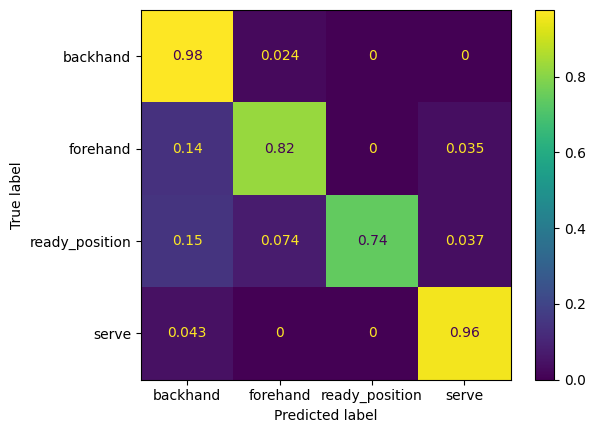

In [67]:
# Calculate class probabilities
preds = np.argmax(probs, axis=1)

classes = ("backhand", "forehand", "ready_position", "serve")

# Get ground truth labels
gt = []
for inputs, labels in test_loader:
        labels = labels.data.cpu().numpy()
        gt.extend(labels) 


# Build confusion matrix
cm = confusion_matrix(gt, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

We have an 86% accuracy! We also see that the model did very well on backhand and serve classification, while being more confused in forehand and ready position. With this, we conclude our experiment by taking this accuracy as a success.

# CONCLUSIONS

During this small project there was lots of learning and mistakes along the way. Being new to Pytorch and Computer Vision there was a lot to figure out and i tried to do everything mostly on my own to truly learn about the topic. I think the end-result is pretty good in terms of accuracy while also interpretability. Some further improvements could be made like using other models or cropping images manually around the player, but I reckon this is a good enough result for the problem at hand. 

One of the key learnings was the importance of looking at the explainability of the model. Previously I had created a hand-made model with really good results, but when looking at Grad-CAM, it was all over the place, not focusing player. This made me realize the model was not really learning but memorizing some data even with the data augmentation. The realization lead me to try different CNN architectures and see that we had too few data to train a good model from scratch, and that the only way forward was transfer learning.

And this is a wrap! In the future I will do more of this project to keep learning about different aspects of CV, so stay tuned. 